<a href="https://colab.research.google.com/github/MunkiPark/Deeplearning-Application/blob/main/NLP3/NLP_3_batch_nomalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP part 3: batch normalization
references: "Delving Deep into Rectifiers:Surpassing Human-Level Performance on ImageNet Classification" https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
"Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" https://asvk.cs.msu.ru/~sveta/%D1%80%D0%B5%D1%84%D0%B5%D1%80%D0%B0%D1%82/batch_normalization.pdf

In [ ]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # For making figures
# Display plots inline in Jupyter notebooks
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read in all the words from the file 'names.txt'
words = open('/content/drive/MyDrive/DeepApp/names.txt', 'r').read().splitlines()
words[:8]  # Display the first 8 words to verify

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)  # Check the total number of words in the dataset

32033

In [ ]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))        # Unique characters sorted
stoi = {s: i+1 for i, s in enumerate(chars)}     # Map chars to integers starting from 1
stoi['.'] = 0                                    # Add special token '.' mapped to 0
itos = {i: s for s, i in stoi.items()}           # Inverse mapping from integers to chars
vocab_size = len(itos)                           # Total number of unique characters including '.'
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# Build the dataset
block_size = 3  # Context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size                  # Initialize context with padding tokens (0)
        for ch in w + '.':                          # Append '.' to indicate the end of a word
            ix = stoi[ch]                           # Convert character to integer index
            X.append(context)                       # Add current context to inputs
            Y.append(ix)                            # Add target character index to outputs
            context = context[1:] + [ix]            # Slide context window and include new character
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)        # Shuffle the words randomly
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Split the data into training, validation, and test sets
Xtr, Ytr = build_dataset(words[:n1])         # 80% for training
Xdev, Ydev = build_dataset(words[n1:n2])     # 10% for validation
Xte, Yte = build_dataset(words[n2:])         # 10% for testing

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10        # The dimensionality of the character embedding vectors
n_hidden = 200     # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)    # For reproducibility

# Initialize parameters
C = torch.randn((vocab_size, n_embd), generator=g)              # Embedding matrix : (27, 10) -> flatten 처리 될 예정

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  # First layer weights : (270, 200)
b1 = torch.randn(n_hidden, generator=g)                         # First layer biases : (200,)
W2 = torch.randn((n_hidden, vocab_size), generator=g)           # Output layer weights : (200, 27)
b2 = torch.randn(vocab_size, generator=g)                       # Output layer biases initialized to zero : (27,)

parameters = [C, W1, W2, b1, b2]                      # List of all parameters
print(sum(p.nelement() for p in parameters))          # Number of parameters in total
for p in parameters:
    p.requires_grad = True                            # Enable gradient computation for optimization


11897


In [ ]:
# same optimization as last time
max_steps = 200000    # Total number of steps to train
batch_size = 32       # Number of examples in a mini-batch
lossi = []            # List to store the loss values

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)   # Random indices
    Xb, Yb = Xtr[ix], Ytr[ix]                                         # Batch X, Y -> 32개의 random한 sample(alphabet 3개의 나열) 가짐 / Xb, Yb = (32, 3) : 32개의 sample, sample당 3글자

    # Forward pass
    emb = C[Xb]                           # Embed the characters into vectors -> 32개의 sample에 embadding / emb = (32, 3, 10) : 32개의 sample, sample당 3글자, 글자당 10개의 embadding
    embcat = emb.view(emb.shape[0], -1)   # Concatenate the embeddings -> flatten : (32, 3, 10) -> (32, 30)
    # Linear layer
    hpreact = embcat @ W1 +b1             # Hidden layer pre-activation -> (30, 200)
    h = torch.tanh(hpreact)               # Apply tanh activation function
    logits = h @ W2 + b2                  # Output layer computations -> (200, 27)
    loss = F.cross_entropy(logits, Yb)    # Compute loss

    # Backward pass
    for p in parameters:
        p.grad = None                    # Reset gradients to zero
    loss.backward()                      # Compute gradients

    # Update
    lr = 0.1 if i < 100000 else 0.01     # Adjust learning rate during training
    for p in parameters:
        p.data += -lr * p.grad           # Update parameters using gradient descent

    # Track stats
    if i % 10000 == 0:                   # Print loss every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    # Store the log of the loss

    if i >= 1000:    # to Fully optimize, comment this block
        break

      0/ 200000: 27.8817


For now, the initialization is very bad. we have loss: 27  
We want more uniform output (or values close to 0)  
As a solution, we make b2$\times$0 and w2$\times$0.01 --> see results

In [ ]:
# Assuming random prob for each alphabet, we expect loss = -log(1/27)=3.29
-torch.tensor(1/27).log()

tensor(3.2958)

Another issue is hidden layer h  
if we see before tanh and after tanh, after tanh values mostly have close to 1 or -1 -->gradient saturation  
![image](./fig/tanh.jpg)

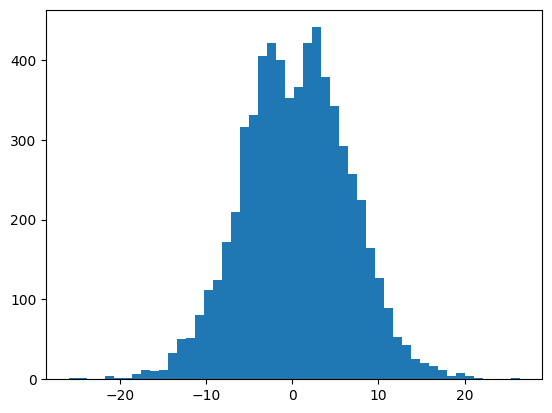

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50) # 위 셸에서 embcat @ W1 +b1를 그래프로 나타낸 것 : 결과값들의 대부분이 0에 몰려있지만 -1과 1 사이에 있는 값보다는 1과 3,-1과 -3 사이의 값들이 대부분일 거임
plt.show() # -1과 1사이에 있는 값은 0 바로 위의 막대밖에 없다고 봐도 될 듯

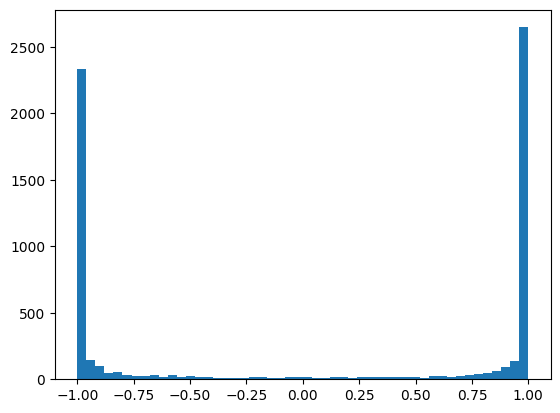

In [ ]:
plt.hist(h.view(-1).tolist(),50) # 위 hpreact를 tanh에 넣은 결과 -> 대부분의 값들이 -1과 1사이에 있지 않아 tanh의 결과가 -1과 1쪽에 몰림
plt.show()

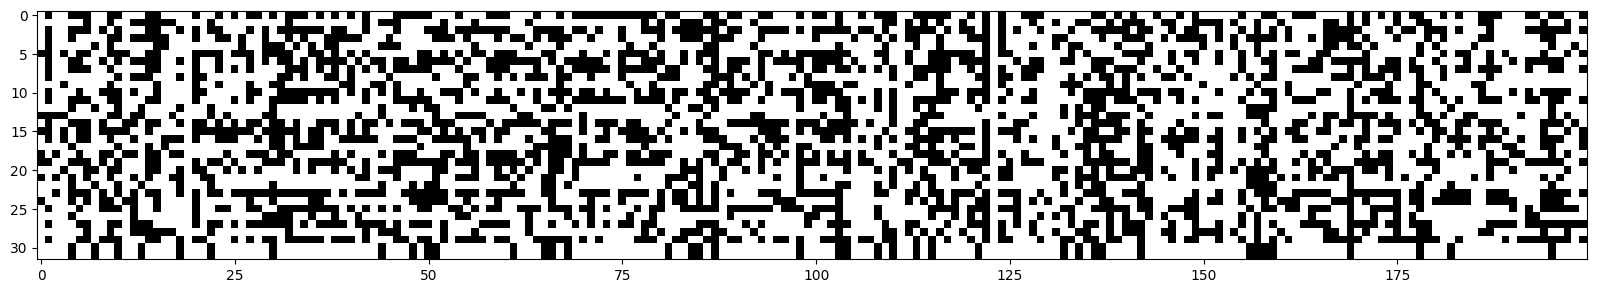

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
plt.show()

Solution  
hpreact has too wide distribution (too large numbers pos/neg) : -1과 1사이에 실수로 몰려있어야 할 값들이 정수 범위로 퍼져있음  
--> make b1* 0, make w1 * 0.1 or w1 * 0.2  
plot again!!

But what numbers should we choose?
There exist many initialization methods. Let's look at Kaiming initialization  https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal

 torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)  
 fan_in:number of node in the previous layer

tensor(-0.0095) tensor(0.9984)
tensor(0.0007) tensor(1.0004)


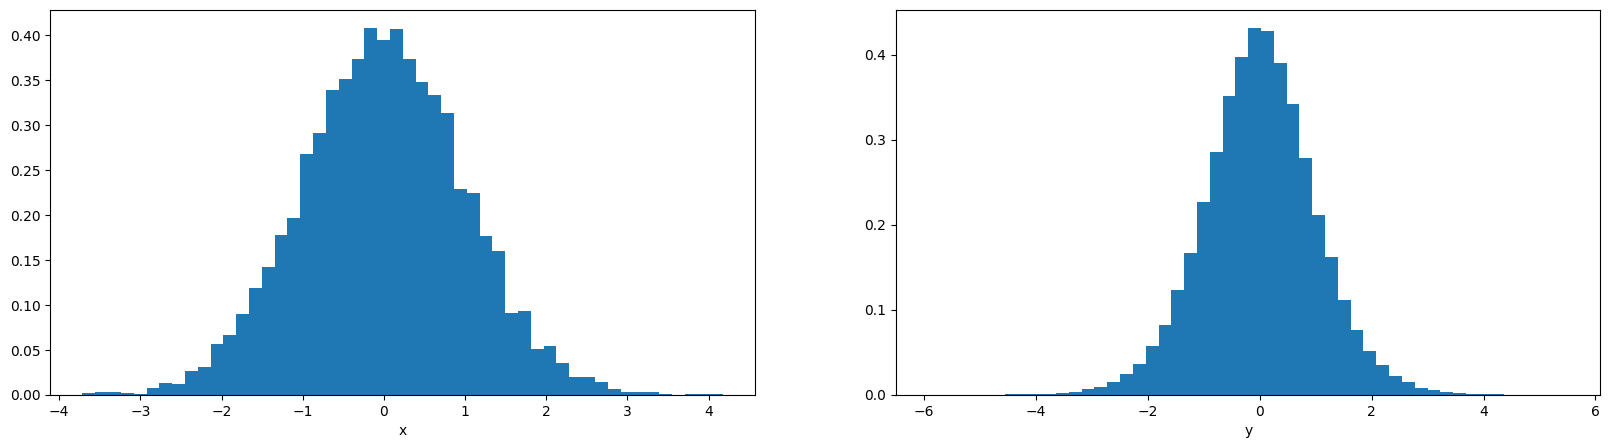

In [ ]:
fan_in = torch.tensor(10)
x = torch.randn(1000,fan_in)
w = torch.randn(fan_in,200) / fan_in**0.5   #*0.2 makes y to shrink. in order to make y to have std=1, we must divide by srqt(fan_in) --> /fan_in**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.xlabel('x')
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.xlabel('y')
plt.show()

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking, Disable gradient tracking for evaluation
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]                                    # Select the dataset based on split
  emb = C[x] # (N, block_size, n_embd)  Get embeddings for the inputs
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1    # Compute hidden layer pre-activations
  h = torch.tanh(hpreact) # (N, n_hidden) Apply tanh activation
  logits = h @ W2 + b2 # (N, vocab_size)  Compute logits
  loss = F.cross_entropy(logits, y)   # Compute loss
  print(split, loss.item())            # Print loss for the split

split_loss('train')                           # Evaluate and print loss for training set
split_loss('val')                             # Evaluate and print loss for validation set

train 3.91969895362854
val 3.917461633682251


In modern deep learning, initialization is much less sensitive due to many techniques such as Batchnorm, Optimizer (RMSProp, Adam, etc), residual network so on.
Now, batchnormalization!!
In Batch normalizations, we want hidden node (pre-activation) to be normalized batch-wise.

In [ ]:
hpreact.shape # (32, 30) @ (30, 200)의 결과 = (32, 200)

torch.Size([32, 200])

In [ ]:
hpreact.mean(0,keepdim=True).shape # hpreact의 32개 data들의 평균 * 200개

torch.Size([1, 200])

In [ ]:
hpreact.std(0,keepdim=True).shape # hpreact의 32개 data들의 분산 * 200개

torch.Size([1, 200])

In [ ]:
hpreact=(hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) # 구한 평균과 분산으로 normalize / 각 연산은 broadcast로 실행됨
hpreact.mean(0,keepdim=True), hpreact.std(0,keepdim=True) # normalize의 결과 : 평균이 0, 분산이 1로 균일해짐

(tensor([[ 7.4506e-09,  3.7253e-09,  7.4506e-09,  7.4506e-09, -7.4506e-09,
          -1.1176e-08,  5.5879e-09,  0.0000e+00, -1.3039e-08,  9.3132e-09,
           7.4506e-09, -7.4506e-09, -7.4506e-09,  7.4506e-09,  1.8626e-09,
          -7.4506e-09,  1.1176e-08, -1.4901e-08,  1.4901e-08,  7.4506e-09,
           0.0000e+00, -9.3132e-09,  1.8626e-08, -9.3132e-09,  7.4506e-09,
           0.0000e+00, -3.7253e-09,  9.3132e-10,  0.0000e+00, -1.4901e-08,
           3.7253e-09,  0.0000e+00,  0.0000e+00,  7.4506e-09,  3.7253e-09,
          -7.4506e-09,  1.4901e-08,  0.0000e+00, -7.4506e-09,  1.4901e-08,
           2.2352e-08,  1.4901e-08,  0.0000e+00, -1.3039e-08,  9.3132e-09,
          -3.7253e-09, -1.4901e-08,  7.4506e-09, -1.4901e-08,  5.5879e-09,
          -7.4506e-09,  0.0000e+00,  0.0000e+00, -3.7253e-09, -1.4901e-08,
          -7.4506e-09,  7.4506e-09, -2.9802e-08, -1.1176e-08,  3.7253e-09,
          -9.3132e-10, -1.3039e-08,  2.2352e-08, -3.7253e-09, -7.4506e-09,
           5.5879e-09,  3

In [ ]:
# BatchNorm parameters : Note that they are also trainable parameters like DNN weights and biases
bngain = torch.ones((1, n_hidden))      # Scale parameter gamma / (1, 200)
bnbias = torch.zeros((1, n_hidden))     # Shift parameter beta / (1, 200)
hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias # 모든 연산은 broadcast로 실행됨

How do we estimate bnmean and bnstd if there is no batch at test stage?
Assume we want to inference a single sample and get output. There is no statistics.
option 1: we can get mean, std from whole training dataset


In [ ]:
# Calibrate the batch norm at the end of training
with torch.no_grad():
    # Pass the entire training set through to compute accurate running mean and std for BatchNorm
    emb = C[Xtr]                              # Get embeddings for the entire training set
    embcat = emb.view(emb.shape[0], -1)       # Flatten embeddings into 2D tensor
    hpreact = embcat @ W1  #+b1               # Compute hidden layer pre-activations
    # Measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)    # Compute mean over entire training set
    bnstd = hpreact.std(0, keepdim=True)      # Compute std over entire training set


option 2: we can compute running mean, std during training.  
with torch.no_grad():  
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani    # Update running mean  
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi       # Update running std

exercise: Compare bnmean and bnmean_running
exercise: what happens if we initialize the weights and bias as zero?

In [ ]:
# MLP revisited
n_embd = 10        # The dimensionality of the character embedding vectors
n_hidden = 200     # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)    # For reproducibility

# Initialize parameters
C = torch.randn((vocab_size, n_embd), generator=g)                            # Embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)  # First layer weights
#W1 = torch.zeros((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size)**0.5)  # First layer weights
# b1 = torch.randn(n_hidden, generator=g) * 0.01                             # First layer biases (not used) : 어차피 아래에서 bngain을 빼서 옮길 것이기 때문에 의미가 없어짐
b1 = torch.zeros(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01                 # Output layer weights
b2 = torch.randn(vocab_size, generator=g)                                    # Output layer biases initialized to zero

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))      # Scale parameter gamma
bnbias = torch.zeros((1, n_hidden))     # Shift parameter beta
bnmean_running = torch.zeros((1, n_hidden))  # Running mean for evaluation
bnstd_running = torch.ones((1, n_hidden))    # Running std for evaluation

parameters = [C, W1, W2, b2, bngain, bnbias]          # List of all parameters
print(sum(p.nelement() for p in parameters))          # Number of parameters in total
for p in parameters:
    p.requires_grad = True                            # Enable gradient computation for optimization

12097


In [ ]:
# same optimization as last time
max_steps = 200000    # Total number of steps to train
batch_size = 32       # Number of examples in a mini-batch
lossi = []            # List to store the loss values

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)   # Random indices
    Xb, Yb = Xtr[ix], Ytr[ix]                                         # Batch X, Y

    # Forward pass
    emb = C[Xb]                           # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)   # Concatenate the embeddings
    # Linear layer
    hpreact = embcat @ W1                 # Hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)       # Compute batch mean
    bnstdi = hpreact.std(0, keepdim=True)         # Compute batch std
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias    # Normalize and scale/shift
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani    # Update running mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi       # Update running std
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)              # Apply tanh activation function
    logits = h @ W2 + b2                 # Output layer computations
    loss = F.cross_entropy(logits, Yb)   # Compute loss

    # Backward pass
    for p in parameters:
        p.grad = None                    # Reset gradients to zero
    loss.backward()                      # Compute gradients

    # Update
    lr = 0.1 if i < 100000 else 0.01     # Adjust learning rate during training
    for p in parameters:
        p.data += -lr * p.grad           # Update parameters using gradient descent

    # Track stats
    if i % 10000 == 0:                   # Print loss every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    # Store the log of the loss

    #if i >= 1000:
    #    break

      0/ 200000: 3.8202
  10000/ 200000: 2.0391
  20000/ 200000: 2.5458
  30000/ 200000: 2.0557
  40000/ 200000: 2.2579
  50000/ 200000: 1.7798
  60000/ 200000: 2.1227
  70000/ 200000: 2.3050
  80000/ 200000: 2.3378
  90000/ 200000: 2.0470
 100000/ 200000: 2.2315
 110000/ 200000: 2.2051
 120000/ 200000: 1.6524
 130000/ 200000: 1.8711
 140000/ 200000: 2.1301
 150000/ 200000: 1.9607
 160000/ 200000: 2.0182
 170000/ 200000: 2.3545
 180000/ 200000: 2.0289
 190000/ 200000: 2.0232


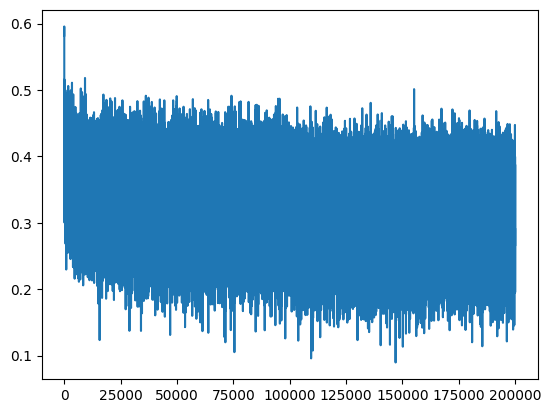

In [ ]:
# Plot the loss over iterations
plt.plot(lossi)
plt.show()

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking, Disable gradient tracking for evaluation
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]                                    # Select the dataset based on split
  emb = C[x] # (N, block_size, n_embd)  Get embeddings for the inputs
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1    # Compute hidden layer pre-activations
  # Apply BatchNorm using the running mean and std
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden) Apply tanh activation
  logits = h @ W2 + b2 # (N, vocab_size)  Compute logits
  loss = F.cross_entropy(logits, y)   # Compute loss
  print(split, loss.item())            # Print loss for the split

split_loss('train')                           # Evaluate and print loss for training set
split_loss('val')                             # Evaluate and print loss for validation set

train 2.0578136444091797
val 2.1091346740722656


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
# Let's train a deeper network
# The classes we create here have the same API as nn.Module in PyTorch


class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5    # Initialize weights
    self.bias = torch.zeros(fan_out) if bias else None                         # Initialize biases

  def __call__(self, x):
    self.out = x @ self.weight                                                 # Compute linear transformation
    if self.bias is not None:
      self.out += self.bias                                                    # Add bias if it exists
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])          # Return parameters

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps                                                             # Epsilon to prevent division by zero -> 0으로 나누는 일 없도록 더하는 작은 값
    self.momentum = momentum                                                   # Momentum for running stats -> running mean, running val을 업데이트할 때 업데이트할 비율
    self.training = True                                                       # Training mode flag -> gamma, beta의 training 여부
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)                                               # Scale parameter gamma
    self.beta = torch.zeros(dim)                                               # Shift parameter beta
    # Buffers (trained with momentum update)
    self.running_mean = torch.zeros(dim)                                       # Running mean
    self.running_var = torch.ones(dim)                                         # Running variance

  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)                                          # Batch mean
      xvar = x.var(0, keepdim=True)                                            # Batch variance
    else:
      xmean = self.running_mean                                                # Use running mean during inference -> test등으로 gamma, beta를 학습하는 것이 아니면(batch를 만드는 것이 아니라면) train에서 얻은 running mean을 사용
      xvar = self.running_var                                                  # Use running variance during inference
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)                           # Normalize input
    self.out = self.gamma * xhat + self.beta                                   # Scale and shift
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean  # Update running mean -> 각 배치의 mean을 이용하여 running mean을 업데이트 -> 전체 training data의 mean이 됨
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar     # Update running var
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]                                             # Return parameters

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)                                                   # Apply tanh activation function
    return self.out
  def parameters(self):
    return []                                                                  # Tanh has no parameters

n_embd = 10                                        # Dimensionality of the character embedding vectors
n_hidden = 100                                     # Number of neurons in hidden layers
g = torch.Generator().manual_seed(2147483647)      # For reproducibility

C = torch.randn((vocab_size, n_embd), generator=g) # Initialize embedding matrix
layers = [                                         # Define the sequence of layers
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),     # Input to first hidden layer
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                # Second hidden layer
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                # Third hidden layer
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                # Fourth hidden layer
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                # Fifth hidden layer
  Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),                    # Output layer
]
# Commented alternative layers without BatchNorm
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1                                                        # Reduce gamma in last BatchNorm layer ->마지막 배치놈 layer의 감마값을 축소
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0                                                        # Apply scaling to weights

parameters = [C] + [p for layer in layers for p in layer.parameters()]           # Collect all parameters
print(sum(p.nelement() for p in parameters))                                     # Print total number of parameters
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# Same optimization as last time
max_steps = 200000                                   # Total number of training iterations
batch_size = 32                                      # Batch size for mini-batch gradient descent
lossi = []                                           # List to store loss values
ud = []                                              # List to store parameter update statistics

for i in range(max_steps):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # Random batch indices
  Xb, Yb = Xtr[ix], Ytr[ix]                                        # Get mini-batch inputs and targets

  # Forward pass
  emb = C[Xb]                                                      # Embed the input indices
  x = emb.view(emb.shape[0], -1)                                   # Flatten embeddings
  for layer in layers:
    x = layer(x)                                                   # Forward pass through network
  loss = F.cross_entropy(x, Yb)                                    # Compute cross-entropy loss

  # Backward pass
  for layer in layers:
    layer.out.retain_grad()                                        # Retain gradients for debugging -> 중간 변수의 기울기를 확인 가능
  for p in parameters:
    p.grad = None                                                  # Reset gradients
  loss.backward()                                                  # Backpropagate

  # Update
  lr = 0.1 if i < 150000 else 0.01                                 # Adjust learning rate
  for p in parameters:
    p.data += -lr * p.grad                                         # Update parameters

  # Track stats
  if i % 10000 == 0:                                               # Print loss every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())                                # Store log10 of loss
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])  # Update stats

  # if i >= 1000:
    # break  # AFTER_DEBUG: would remove to run full optimization

      0/ 200000: 2.5356
  10000/ 200000: 2.2481
  20000/ 200000: 2.3801
  30000/ 200000: 1.9018
  40000/ 200000: 2.1323
  50000/ 200000: 2.1383
  60000/ 200000: 1.7381
  70000/ 200000: 1.9834
  80000/ 200000: 2.2764
  90000/ 200000: 1.8918
 100000/ 200000: 1.8508
 110000/ 200000: 1.8354
 120000/ 200000: 1.8027
 130000/ 200000: 1.9075
 140000/ 200000: 1.9338
 150000/ 200000: 2.1322
 160000/ 200000: 2.1914
 170000/ 200000: 2.2092
 180000/ 200000: 1.9086
 190000/ 200000: 1.7646


layer 2 (      Tanh): mean -0.00, std 0.69, saturated: 18.41%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 19.97%
layer 8 (      Tanh): mean +0.01, std 0.78, saturated: 19.94%
layer 11 (      Tanh): mean +0.01, std 0.80, saturated: 22.00%
layer 14 (      Tanh): mean +0.03, std 0.82, saturated: 23.81%


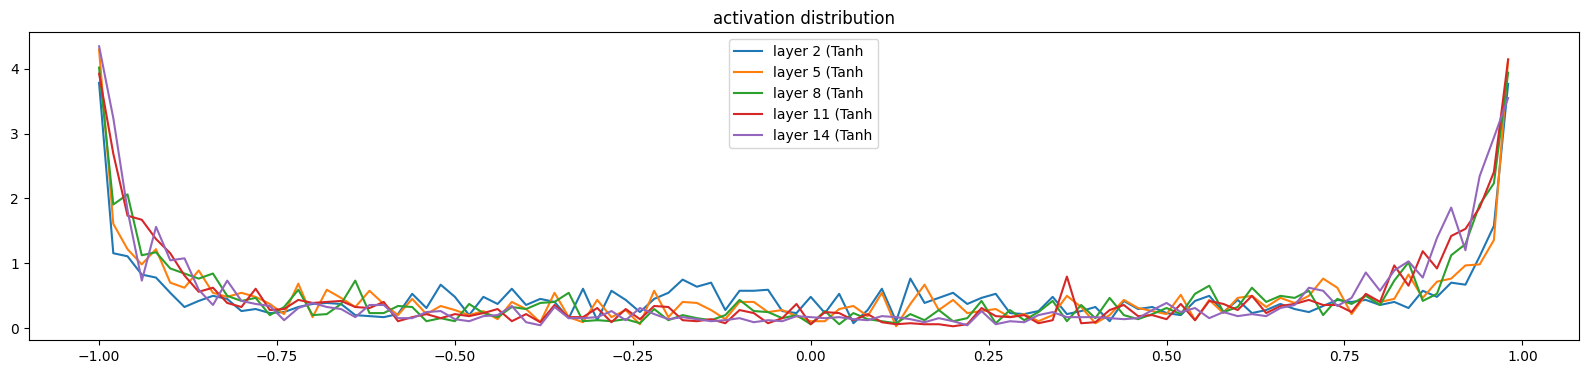

In [ ]:
# Visualize activation histograms for each Tanh layer
plt.figure(figsize=(20, 4))                              # Set figure size
legends = []
for i, layer in enumerate(layers[:-1]):                  # Loop over layers, excluding the last
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)            # Compute histogram
    plt.plot(hx[:-1].detach(), hy.detach())              # Plot histogram
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);                                     # Add legend
plt.title('activation distribution')                     # Set plot title
plt.show()

layer 2 (      Tanh): mean +0.000000, std 4.872127e-03
layer 5 (      Tanh): mean +0.000000, std 3.645662e-03
layer 8 (      Tanh): mean +0.000000, std 3.408411e-03
layer 11 (      Tanh): mean +0.000000, std 3.314346e-03
layer 14 (      Tanh): mean -0.000000, std 4.367427e-03


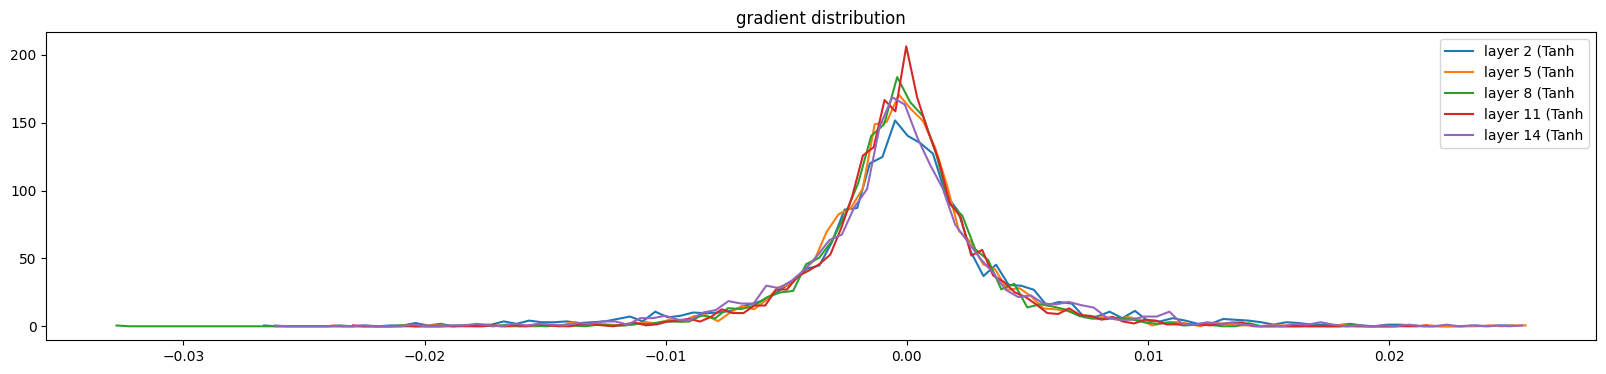

In [ ]:
# Visualize gradient histograms for each Tanh layer
plt.figure(figsize=(20, 4))                              # Set figure size
legends = []
for i, layer in enumerate(layers[:-1]):                  # Loop over layers, excluding the last
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (
        i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)            # Compute histogram of gradients
    plt.plot(hx[:-1].detach(), hy.detach())              # Plot histogram
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);                                     # Add legend
plt.title('gradient distribution')                       # Set plot title
plt.show()

weight   (27, 10) | mean -0.000000 | std 2.596195e-02 | grad:data ratio 2.281307e-02
weight  (30, 100) | mean -0.000196 | std 1.084849e-02 | grad:data ratio 2.696703e-02
weight (100, 100) | mean +0.000012 | std 5.514307e-03 | grad:data ratio 2.257587e-02
weight (100, 100) | mean -0.000008 | std 5.119251e-03 | grad:data ratio 2.123029e-02
weight (100, 100) | mean +0.000068 | std 4.921328e-03 | grad:data ratio 2.132825e-02
weight (100, 100) | mean +0.000026 | std 4.957199e-03 | grad:data ratio 2.294290e-02
weight  (100, 27) | mean +0.000110 | std 1.091165e-02 | grad:data ratio 3.077977e-02


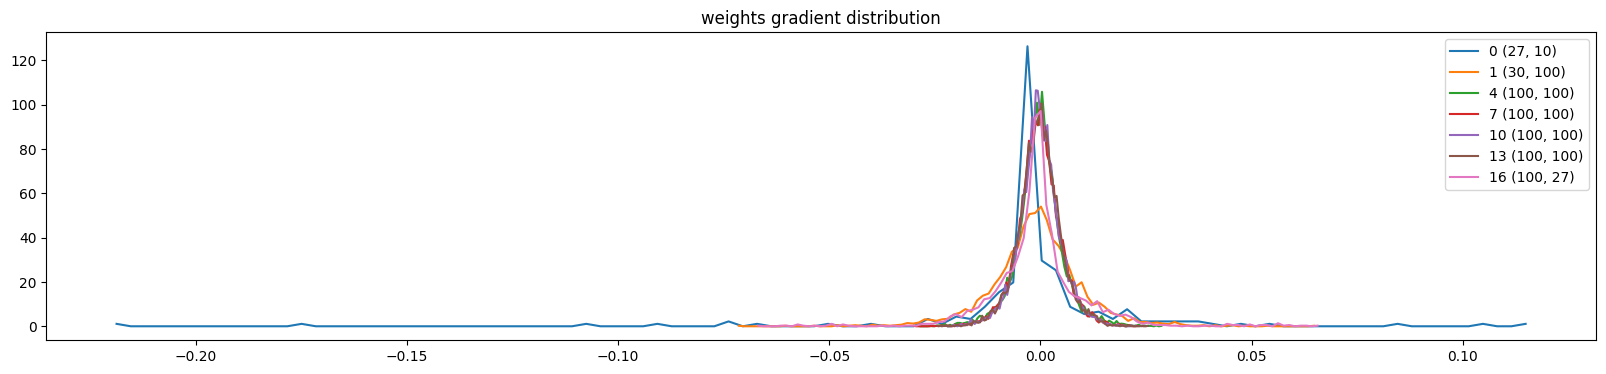

In [ ]:
# Visualize gradient histograms for weights
plt.figure(figsize=(20, 4))                              # Set figure size
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:                                        # Only consider weight matrices
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (
        tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)            # Compute histogram
    plt.plot(hx[:-1].detach(), hy.detach())              # Plot histogram
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)                                      # Add legend
plt.title('weights gradient distribution');              # Set plot title
plt.show()

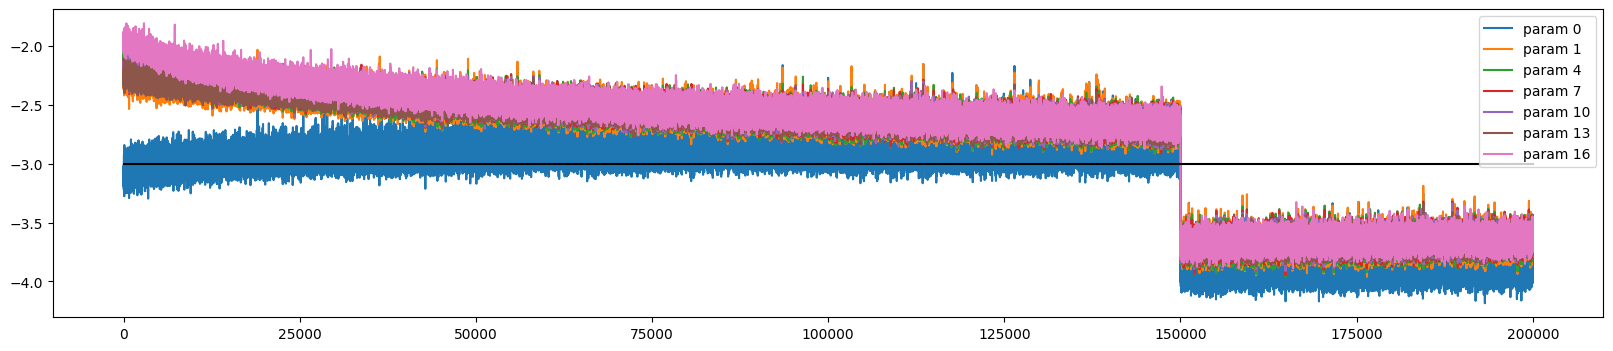

In [ ]:
plt.figure(figsize=(20, 4))                              # Set figure size
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:                                        # Only consider weight matrices
    plt.plot([ud[j][i] for j in range(len(ud))])         # Plot update-to-data ratio
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')                    # Line at expected ratio
plt.legend(legends);                                     # Add legend
plt.show()


In [ ]:
@torch.no_grad()                                         # Disable gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]                                               # Select dataset
  emb = C[x]                                             # Get embeddings
  x = emb.view(emb.shape[0], -1)                         # Flatten embeddings
  for layer in layers:
    x = layer(x)                                         # Forward pass
  loss = F.cross_entropy(x, y)                           # Compute loss
  print(split, loss.item())                              # Print loss

# Put layers into eval mode
for layer in layers:
  layer.training = False                                 # Set to evaluation mode
split_loss('train')                                      # Compute loss on training set
split_loss('val')                                        # Compute loss on validation set

train 1.9995646476745605
val 2.077711582183838


In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)  # New RNG seed

for _ in range(20):  # Generate 20 samples
    out = []
    context = [0] * block_size  # Initialize context with padding tokens
    while True:
        # Forward pass through the network
        emb = C[torch.tensor([context])]  # Get embeddings for current context
        x = emb.view(emb.shape[0], -1)  # Flatten embeddings
        for layer in layers:
            x = layer(x)  # Forward pass
        logits = x
        probs = F.softmax(logits, dim=1)  # Compute probabilities
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # Sample index
        # Update context and output
        context = context[1:] + [ix]  # Shift context window
        out.append(ix)  # Append index to output
        if ix == 0:  # If end token is sampled, break
            break
    print(''.join(itos[i] for i in out))  # Decode and print the generated word

montaymyah.
see.
mad.
rylla.
emmasiendra.
grace.
kaitlin.
shi.
jenneden.
sananaraelynn.
hotalin.
shubergiaghiel.
kinjo.
jennox.
teriffuna.
geder.
yarun.
elsyn.
ajahsanyah.
halisa.


In [ ]:
# DONE; BONUS content below

In [ ]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))
  plt.show()

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# Linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)   # Input vector
w = torch.randn((n, n), requires_grad=True, generator=g)  # Weight matrix
x = w @ inp                                            # Linear transformation
# BatchNorm layer ---
xmean = x.mean()                                       # Compute mean
xvar = x.var()                                         # Compute variance
out = (x - xmean) / torch.sqrt(xvar + 1e-5)            # Batch normalization
# ----
loss = out @ torch.randn(n, generator=g)               # Compute scalar loss
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()                                        # Backpropagate

print('inp std: ', inp.std().item())                   # Print std of input
print('w std: ', w.std().item())                       # Print std of weights
print('x std: ', x.std().item())                       # Print std of pre-BN activations
print('out std: ', out.std().item())                   # Print std of post-BN activations
print('------')
print('out grad std: ', out.grad.std().item())         # Print grad std of out
print('x grad std: ', x.grad.std().item())             # Print grad std of x
print('w grad std: ', w.grad.std().item())             # Print grad std of weights
print('inp grad std: ', inp.grad.std().item())         # Print grad std of input

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953052997589111
